In [1]:
import warnings
warnings.filterwarnings("ignore")
import pylab as plt
import os.path as op
path_data = op.join(op.expanduser('~'), 'nilearn_data/')
%matplotlib inline

## Preparing the Data

### Retreive and load the fMRI data from Haxby study

In [2]:
from nilearn import datasets
from nilearn import plotting

# By default the 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(data_dir = path_data)
fmri_filename = haxby_dataset.func[0]

# Print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' % fmri_filename)

First subject functional nifti images (4D) are at: C:\Users\jzm0144\nilearn_data/haxby2001\subj2\bold.nii.gz


E:\Janzaib_Masood\Anaconda\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


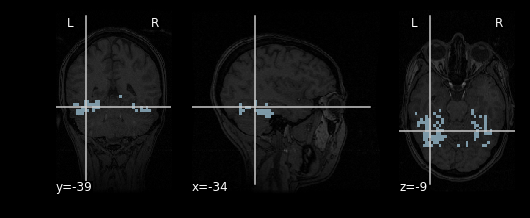

In [3]:
mask_filename = haxby_dataset.mask_vt[0]
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0], cmap= 'Paired')

In [5]:
from nilearn.input_data import NiftiMasker
# Load the mask from the disk
masker = NiftiMasker(mask_img = mask_filename, standardize = True)

# Fitting the transformer initializes it to operate on new data
masker.fit(fmri_filename)

C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\_utils\cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
      mask_args=None,
      mask_img='C:\\Users\\jzm0144\\nilearn_data/haxby2001\\subj2\\mask4_vt.nii.gz',
      mask_strategy='background', memory=Memory(location=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

In [6]:
# Now we will transform our fMRI data
fmri_masked = masker.transform(fmri_filename)

C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\_utils\cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [7]:
fmri_masked.shape

(1452, 464)

In [8]:
type(fmri_masked)

numpy.ndarray

## Load the behavioral labels 

In [9]:
import pandas as pd
import numpy as np

# Load target information as string and give a numerical indentifier to each
labels = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(labels.head())

E:\Janzaib_Masood\Anaconda\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


  labels  chunks
0   rest       0
1   rest       0
2   rest       0
3   rest       0
4   rest       0


In [10]:
print(labels.shape)
print(fmri_masked.shape)

(1452, 2)
(1452, 464)


In [11]:
print(labels['labels'].values[:50])

['rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'scissors' 'scissors'
 'scissors' 'scissors' 'scissors' 'scissors' 'scissors' 'scissors'
 'scissors' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'rest' 'rest' 'rest' 'rest'
 'rest' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'rest'
 'rest' 'rest' 'rest' 'rest' 'shoe']


## Restrict the analysis to cats and faces

In [12]:
# Create a mask with Pandas
condition_mask = labels.eval('labels in ["face", "cat"]').values

# Create a mask with Numpy
# condition_mask = np.logical_or(target == b'face', target == b'cat')

In [13]:
# We apply this mask along the "samples" axis to restrict the
# classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]
targets = labels[condition_mask]['labels'].values

In [16]:
print(fmri_masked.shape)
print(targets.shape)

(216, 464)
(216,)


## Decoding with an SVM

Now we have all the components we will need to fit a model. We have:           
1: Masked a subset of voxels in which we are interested.                       
2: Vectorized those masked voxels so that they have shape (n_samples,              n_features). This is x                                                      
3: Extracted a set of labels, one for each timepoint, corresponding to the        stimulus being shown at that time. This is y                                
4: Masked out time dimension so that we only have two classes of interest.     
                                                                               
Let's fit our model. Use Sklearn on the fmri_masked data.                       
                                                                               
As a decoder, we will use Support Vector Classification, with a linear kernel. 

In [17]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [18]:
svc.fit(fmri_masked, targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Predicting with our model/ Assessing the Model

In [19]:
# Here we will predict with the same input training data
prediction = svc.predict(fmri_masked)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

In [20]:
from sklearn.metrics import accuracy_score

print(accuracy_score(targets, prediction))

1.0


OMG!! , This is supercool. we got 100%.


But wait a minute.. We're mistaken. This is not a real test.

Real test is, when you test you model with unseen data.

## Validation

In [21]:
svc.fit(fmri_masked[:-30], targets[:-30])

prediction = svc.predict(fmri_masked[-30:])

print((prediction == targets[-30:]).sum() / len(targets[-30:]))

0.6666666666666666


In [22]:
# See CrossValidation later, that must help

## Inspecting the model weights

In [25]:
coef_ = svc.coef_
print(coef_)

[[-4.52870742e-02 -3.25630327e-03 -1.84344188e-02 -3.62234716e-02
   3.19974318e-02  3.13673295e-02  2.38867665e-02 -5.90316684e-02
  -1.47178645e-02 -1.77979447e-02  2.11871064e-02 -1.06412506e-02
  -2.90834630e-03 -3.22934200e-02  6.45974621e-04  2.60102078e-02
   1.09523448e-02  1.51133949e-04  2.78173210e-02 -3.65803817e-02
   1.88985087e-02 -9.93080637e-02 -6.31374484e-02  1.91007054e-02
   3.89092513e-02 -2.28917600e-02 -1.72669571e-03 -2.72507317e-02
   3.13590525e-02  9.97109033e-02  1.87843861e-02 -8.31900356e-02
  -2.28859465e-03 -3.05370945e-02 -2.54956056e-02 -5.43890331e-02
  -1.49296385e-02 -1.52813498e-02 -4.37493132e-02 -2.60248647e-02
  -2.01607178e-02 -3.98179715e-02  3.52554298e-02  2.33804943e-02
  -2.16755239e-03  3.77410948e-02  5.24437162e-03  1.58836803e-02
   7.11192415e-03  3.96629408e-02  3.67000622e-02  9.56506650e-03
  -1.40701097e-02  6.84676070e-04 -3.26360197e-02  1.69525892e-02
  -1.54696216e-02 -4.99240271e-02  4.46819217e-02 -1.40366057e-01
  -4.61067

In [26]:
print(svc.coef_.shape)
print(fmri_masked.shape)

(1, 464)
(216, 464)


### Turning the weights into a Nifti Image

In [27]:
coef_img = masker.inverse_transform(coef_)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_f

C:\Users\jzm0144\AppData\Roaming\Python\Python37\site-packages\nilearn\_utils\cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [28]:
coef_img.to_filename('haxby_svc_weights.nii.gz')

## Visualizing our Weights

E:\Janzaib_Masood\Anaconda\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


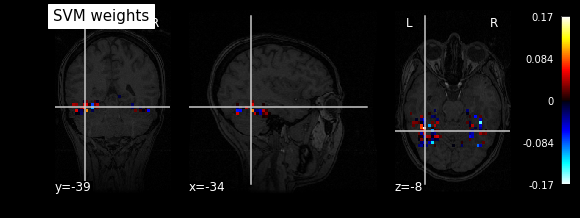

In [29]:
from nilearn.plotting import plot_stat_map, show

plot_stat_map(coef_img, bg_img = haxby_dataset.anat[0], title = "SVM weights")